## ¿Qué problema se va a resolver?
El tema de investigación surgió por la necesidad que tienen las empresas operadoras de taxis de la ciudad de Bogotá, estas vienen presentando una creciente problemática de indisponibilidad de servicios de taxis en sus plataformas, esto suceso ocurre principalmente en algunas zonas u horarios específicos.
La empresa Taxis Libres (TL), una de las más grandes operadoras de servicios de taxis de la ciudad, ha empezado a recibir una gran cantidad de inconformidades por partes de los usuarios recurrentes de la plataforma por esta misma causa. Solo en el mes de mayo del 2022 la plataforma recibió alrededor de 1.2 millones de solicitudes de servicios de taxis de los cuales el 57% de esas solicitudes fueron abandonadas o rechazadas, lo que los llevó a analizar qué estaba pasando con la prestación de servicios internamente, en esa revisión realizada durante el mismo periodo de tiempo se obtuvieron las principales causas reportadas en la plataforma y que se listarán a continuación:

•	El usuario se fue

•	El vehículo se demoró en llegar

•	El usuario tomó otro taxi

Al identificar las causas de los servicios abandonados y rechazados, la empresa se planteó a resolver la siguiente pregunta al problema presentado.
¿Como reducir la alta cantidad de inconformidades de los usuarios recurrentes de la plataforma prediciendo sus comportamientos durante la semana y así programarles sus servicios de forma anticipada?

## Objetivo general
Diseñar un método para predecir las solicitudes de servicios de los usuarios recurrentes "de empresas de servicios de" taxis en la ciudad Bogotá - Colombia, "mediante" modelos de ML.


Evaluar el desempeño de modelos de ML para predecir
las solicitudes de servicios de los usuarios recurrentes de empresas de servicios de taxis en la ciudad Bogotá -  Colombia
basados en el comportamiento dentro de la plataforma.

## Objetivos específicos (Detallar las actividades)
• Revisar la literatura de al menos 10 artículos de proyectos relacionados (pendiente)

• Analizar los datos de los últimos 6 meses de servicios de la empresa taxis libres.

• Determinar las variables significativas a ser empleadas en los modelos de ML.

• Evaluar diferentes modelos de ML para la predicción de solicitudes.

## ¿Que solución propone al problema?
El diseño de un modelo predictivo de solicitudes de servicios de taxis basados en comportamientos de usuarios recurrentes de plataformas móviles para empresas de transporte

## ¿Cómo lo pretende solucionar?
Utilizando un modelo de clasificación donde se agrupe la información de los servicios que han tomado los usuarios por días de las semanas y horarios, determinando si en ese día y a esa hora se va a tomar un servicio.

## ¿Que resultados que espera obtener?
Se espera obtener listado por día de las semanas con todos los horarios del día y un determinador que indique si el servicio se va a tomar o no en ese horario. 

### ANALISIS EXPLORATORIO DE DATOS

In [381]:
#from google.colab import drive
#drive.mount('/content/drive')

Definición de librerías del proyecto

In [382]:
#librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.multiclass import OneVsRestClassifier
#from sklearn.metrics import plot_confusion_matrix
from matplotlib.colors import ListedColormap
#from mlxtend.plotting import plot_decision_regions
#modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron

#from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score

import numpy as np
#from numpy import NaN
from datetime import datetime, timedelta
#from os import name
import math

Definición de parámetros iniciales

In [383]:
TRAIN_WEEK = 6.0
TEST_WEEK = 1.0
BOGOTA_CODE = 11001
HOURS_OF_DAY = 24
DAYS_OF_WEEK = 7
FORMAT_DATE = '%Y-%m-%d'
FORMAT_COMPLETE_DATE = '%Y/%m/%d %H:%M:%S'
DATE_START_TRAINIG = pd.to_datetime("2022-02-11", format=FORMAT_DATE)
FICHERO_DATA = '../data/SERVICIO_UNIFICADO_2022.parquet.gzip'

#Se obtiene la fecha de inicial de entrenamiento
last_date_dataset = DATE_START_TRAINIG - timedelta(weeks=TRAIN_WEEK)
#Se obtiene la fecha de inicial de entrenamiento
first_date_dataset = DATE_START_TRAINIG + timedelta(weeks=TEST_WEEK)


Se cargan los datos en el dataFrame

In [384]:
#Se lee el archivo de un parquet a un dataframe
df_taxis = pd.read_parquet(FICHERO_DATA) 
#Se visualizan los datos
print("Datos cargados correctamente")

Datos cargados correctamente


Se visualiza la cantidad de servicios en el tiempo

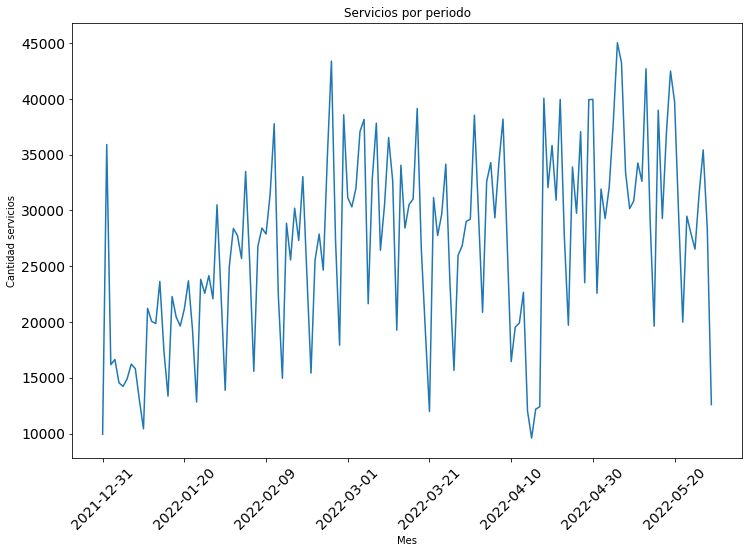

In [385]:
dft = df_taxis.copy()
service_date = pd.to_datetime(dft['FECHACOMPLETA'], format=FORMAT_COMPLETE_DATE)
#Se crea un nuevo campo con la fecha en formato YYYY-MM-DD
dft['FECHA'] = service_date.dt.strftime(FORMAT_DATE)

#Eliminamos las columan que no son útiles para el modelo
dft = dft.drop(columns=["IDCIUDAD","USUARIO","ID","LATITUDDESTINO","LONGITUDDESTINO","LATITUD","LONGITUD","FECHACOMPLETA","ORIGEN","ESTADO"])
#Se eliminan los valores duplicados del dataframe y se ordenan por los campos más relevangtes
dft = dft.drop_duplicates().sort_values(by=['FECHA','TELEFONOORIGEN','DIADESEMANA','HORA'])
#Se reindexa nuevamente el dataFrame
dft = dft.reset_index(drop=True)

dft.groupby(['FECHA'])['FECHA'].count().plot(kind='line',stacked=True, fontsize=14, xlabel="Mes", ylabel="Cantidad servicios", figsize=(12,8), title="Servicios por periodo", rot=45)
plt.show()

In [144]:
dft_new = dft_serie.to_frame(name="SERVICES")
dft_new.index[[0,0]]
#dft_new.drop([5,6], axis=0, inplace=False)

MultiIndex([('2022-05-06',),
            ('2022-05-06',)],
           names=['FECHA'])

Se filtra el dataset con los valores a utilizar en las pruebas del modelo 8 semanas anteriores y una semana después

In [386]:
print(f"Se restringe el dataset desde la fecha:{last_date_dataset} - hasta la fecha:{first_date_dataset}")

#Se particiona el dataframe desde la fecha inicial y hasta la fecha final de entrenamiento
df_taxis = df_taxis[ (pd.to_datetime(df_taxis['FECHACOMPLETA'], format=FORMAT_DATE) >= last_date_dataset) & (pd.to_datetime(df_taxis['FECHACOMPLETA'], format=FORMAT_DATE) <= first_date_dataset) ]
df_taxis = df_taxis.sort_values(by=['FECHACOMPLETA','USUARIO'])

Se restringe el dataset desde la fecha:2021-12-31 00:00:00 - hasta la fecha:2022-02-18 00:00:00


Visualizamos los tipos de datos del dataset

In [387]:
df_taxis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1965568 entries, 7136006 to 6511991
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   ID               int64  
 1   IDCIUDAD         int64  
 2   USUARIO          float64
 3   TELEFONOORIGEN   object 
 4   LATITUD          float64
 5   LATITUDDESTINO   float64
 6   LONGITUD         float64
 7   LONGITUDDESTINO  float64
 8   ESTADO           object 
 9   ORIGEN           object 
 10  FECHACOMPLETA    object 
 11  DIADESEMANA      int64  
 12  HORA             int64  
dtypes: float64(5), int64(4), object(4)
memory usage: 209.9+ MB


In [388]:
df_taxis.head(5)

,ID,IDCIUDAD,USUARIO,TELEFONOORIGEN,LATITUD,LATITUDDESTINO,LONGITUD,LONGITUDDESTINO,ESTADO,ORIGEN,FECHACOMPLETA,DIADESEMANA,HORA
7136006,63983915,11001,2719167.0,3214021236,4.628937,4.57656,-74.202835,-74.11431,ABANDONADO,APP,2021-12-31 19:00:00,6,19
7136005,63983914,11001,8434828.0,3124567009,4.582252,NaN,-74.141698,NaN,ABANDONADO,APP,2021-12-31 19:00:00,6,19
7136007,63983916,11001,8955369.0,3212101273,4.581140,2.95656,-74.167433,-75.28462,CANCELADO,APP,2021-12-31 19:00:00,6,19
7136012,63983921,11001,3276764.0,16753179,4.727365,NaN,-74.043887,NaN,ABANDONADO,IVR,2021-12-31 19:00:01,6,19
7136011,63983920,11001,8447455.0,3102643548,4.660441,NaN,-74.064196,NaN,ABANDONADO,APP,2021-12-31 19:00:01,6,19


## Visualización de datos iniciales

Se validan los datos categoricos de origen

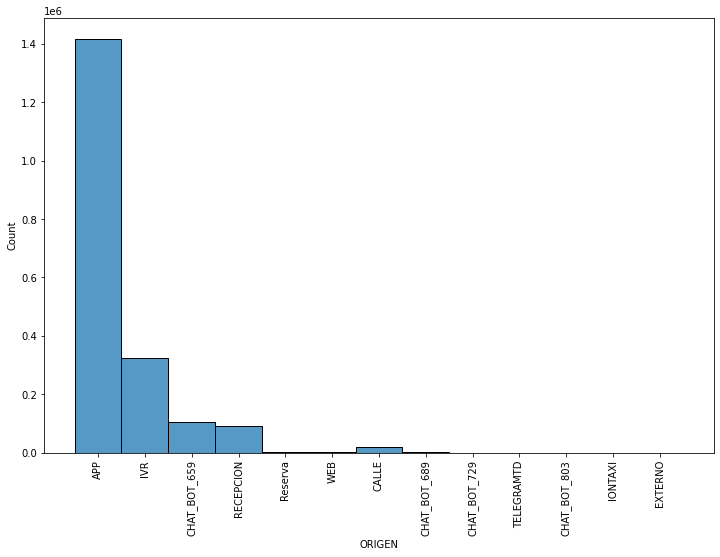

In [389]:
#Se visualiza la cantidad por origen
plt.figure(figsize=(12,8))
sns.histplot(df_taxis['ORIGEN'])
plt.xticks(rotation='vertical')
plt.show()

Se validan los datos categoricos de estado

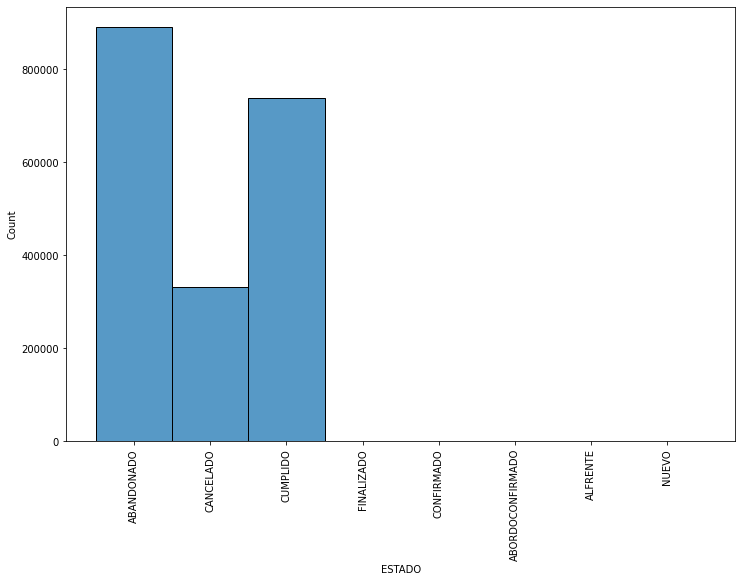

In [390]:
#Se visualiza la cantidad de servicios por estado
plt.figure(figsize=(12,8))
sns.histplot(df_taxis['ESTADO'])
plt.xticks(rotation='vertical')
plt.show()

Se visualizan los datos del dataFrame en un histograma para analizar los datos

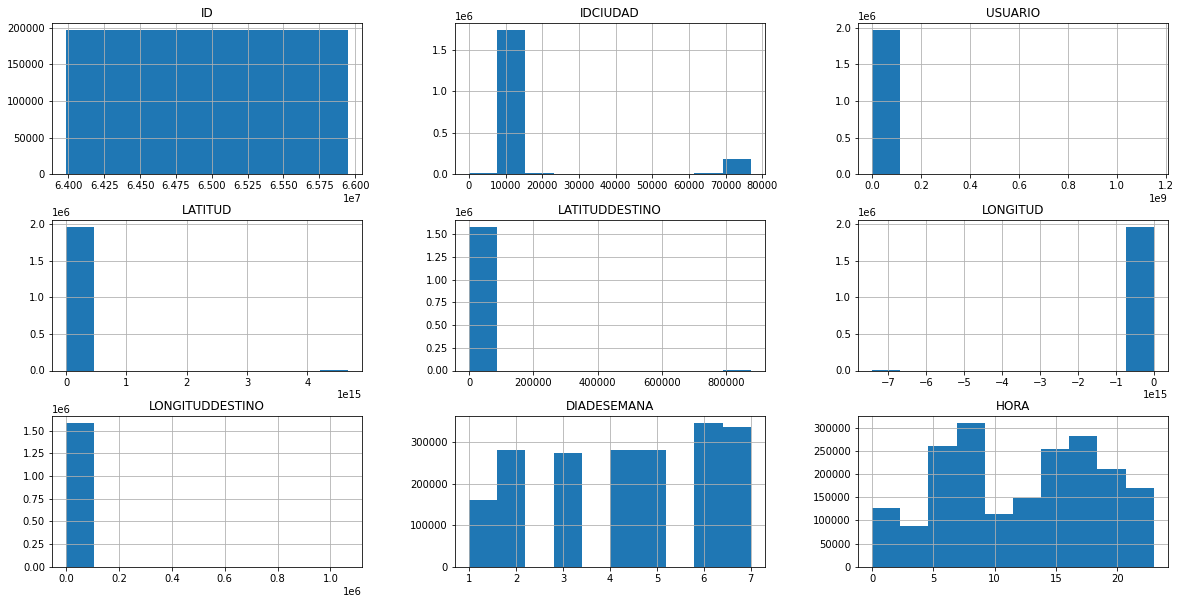

In [391]:
#Se require presentar gráfica de histograma por cada columna o datos de dataframe
df_taxis.hist(figsize=(20,10))
plt.show()

-Se limitan los datos a la ciudad de bogotá.

-Se limita al canal APP que es por donde se reciben la mayoria de los servicios.

-Se limitan los estados a ABANDONADO, CUMPLIDO, CANCELADO Y FINALIZADO que son los validos, el restos son errores del proceso.

In [392]:
#Se filtra el dataset solo para la ciudad de bogotá
df_taxis = df_taxis[df_taxis["IDCIUDAD"]==BOGOTA_CODE]
df_taxis = df_taxis[(df_taxis["ORIGEN"]=="APP")]
df_taxis = df_taxis[(df_taxis["ESTADO"]=="ABANDONADO") | (df_taxis["ESTADO"]=="CUMPLIDO") | (df_taxis["ESTADO"]=="CANCELADO") | (df_taxis["ESTADO"]=="FINALIZADO")]

Se valida cuantos valores nulos tenemos en el dataset

In [393]:
#Contar cuantos datos se encuentran nulos
df_taxis.isnull().sum()

ID                      0
IDCIUDAD                0
USUARIO                 1
TELEFONOORIGEN          0
LATITUD                 0
LATITUDDESTINO     105161
LONGITUD                0
LONGITUDDESTINO    105161
ESTADO                  0
ORIGEN                  0
FECHACOMPLETA           0
DIADESEMANA             0
HORA                    0
dtype: int64

Se crean los campos de fecha sin la hora y el día de la semana

In [394]:
service_date = pd.to_datetime(df_taxis['FECHACOMPLETA'], format=FORMAT_COMPLETE_DATE)
#Se crea un nuevo campo con la fecha en formato YYYY/MM/DD
df_taxis['FECHA'] = service_date.dt.strftime(FORMAT_DATE)
#Se crea un nuevo campo con el mes
df_taxis['MES'] = service_date.dt.month
#Se crea un nuevo campo con la fecha en formato YYYY/MM/DD
df_taxis['DIADESEMANA'] = service_date.map( lambda x: x.isoweekday() )

Se visualizan las corelaciones entre variables

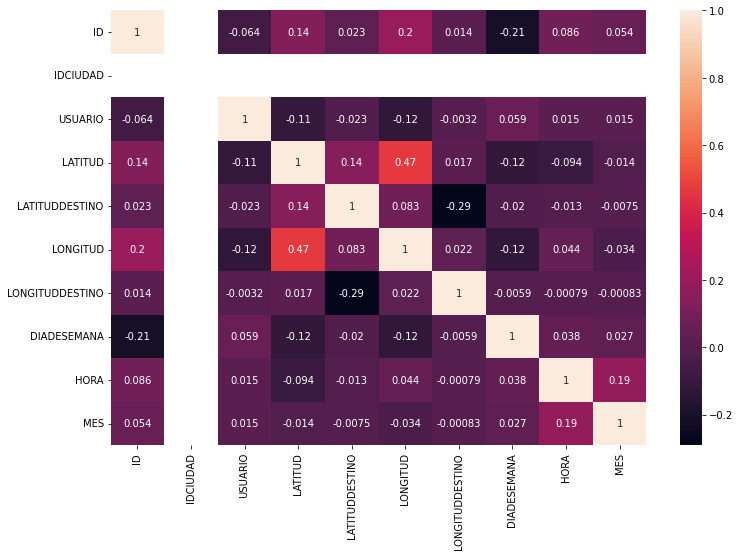

In [395]:
plt.figure(figsize=(12,8))
sns.heatmap(df_taxis.corr(method='pearson'),annot=True)
plt.show()

Se visualiza un histograma con la cantidad de servicios por estado

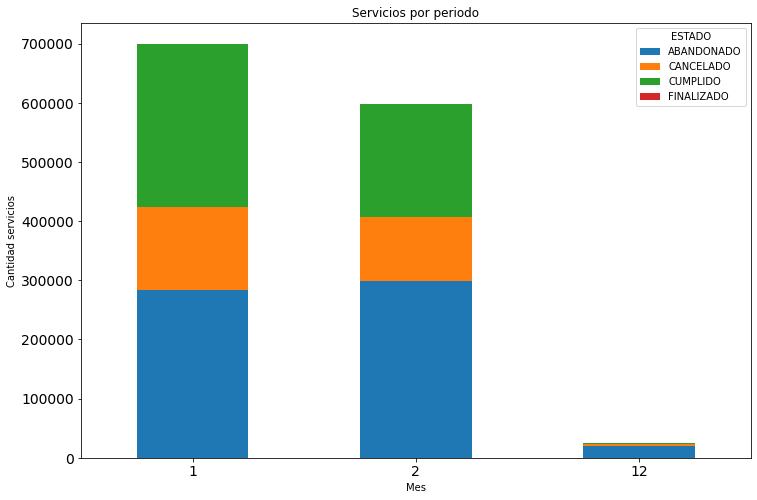

In [396]:
df_taxis.groupby(['MES','ESTADO'])['ID'].count().unstack('ESTADO').plot(kind='bar',stacked=True, fontsize=14, xlabel="Mes", ylabel="Cantidad servicios", figsize=(12,8), title="Servicios por periodo", rot=0)
plt.show()

Se eliminan los datos que no se necesitan para predecir el modelo

In [397]:
#Eliminamos las columan que no son útiles para el modelo
df_taxis = df_taxis.drop(columns=["IDCIUDAD","USUARIO","ID","LATITUDDESTINO","LONGITUDDESTINO","LATITUD","LONGITUD","FECHACOMPLETA","ORIGEN","ESTADO","MES"])
#Se eliminan los valores duplicados del dataframe y se ordenan por los campos más relevangtes
df_taxis = df_taxis.drop_duplicates().sort_values(by=['FECHA','TELEFONOORIGEN','DIADESEMANA','HORA'])
#Se reindexa nuevamente el dataFrame
df_taxis = df_taxis.reset_index(drop=True)
#Se visualizan como queda el dataFrame
df_taxis.head(5)

,TELEFONOORIGEN,DIADESEMANA,HORA,FECHA
0,3002000029,5,21,2021-12-31
1,3002002657,5,22,2021-12-31
2,3002005739,5,20,2021-12-31
3,3002047301,5,19,2021-12-31
4,3002047301,5,20,2021-12-31


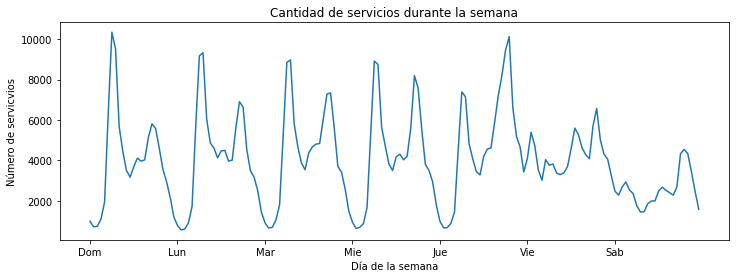

In [398]:
fig, ax = plt.subplots(figsize=(12, 4))
s_taxis = df_taxis.groupby(['DIADESEMANA','HORA'])['FECHA'].count()
s_taxis.plot(ax=ax)
_ = ax.set(
    title="Cantidad de servicios durante la semana",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Dom", "Lun", "Mar", "Mie", "Jue", "Vie", "Sab"],
    xlabel="Día de la semana",
    ylabel="Número de servicvios",
)

Se contabilizan cuantos servicios tiene asignado un teléfono después de eliminar los duplicados

In [399]:
count_services = df_taxis.loc[:,['TELEFONOORIGEN']].value_counts()
count_services

TELEFONOORIGEN
3107584482        222
3503758291        181
3132880597        156
3017223869        146
3044717854        141
                 ... 
3164541446          1
3104568467          1
3164539772          1
3164537852          1
3177475408          1
Length: 156907, dtype: int64

Se observa la distribución de los datos

In [400]:
#Se visualizan los valores de los datos
count_services.describe()

count    156907.000000
mean          4.316104
std           6.880878
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         222.000000
dtype: float64

Se calcula los outliers de los datos

In [401]:
#Se calcula el quartil 25
q25 = count_services.quantile(0.25)
#Se calcula el quartil 50
q50 = count_services.quantile(0.5)
#Se calcula el quartil 75
q75 = count_services.quantile(0.75)
#Se calcula el rango inter quartil
iqr = q75 - q25

print(f"El porcentaje del quartil 25: {q25}")
print(f"El porcentaje del quartil 75: {q75}")
print(f"El rango inter quartil es: {iqr}")

El porcentaje del quartil 25: 1.0
El porcentaje del quartil 75: 4.0
El rango inter quartil es: 3.0


Se calcula el umbral de los valores atípicos

In [402]:
#Se calcula el umbral de los  valores atípicos
outliers_threshold = ( q75 + 3 * iqr )
print(f"El umbral de los valores atípicos es: {outliers_threshold}")
print(f"La cantidad de valores atípicos son: {sum(count_services > outliers_threshold) }")

El umbral de los valores atípicos es: 13.0
La cantidad de valores atípicos son: 9900


Se eliminan los outliers de los datos de train

In [403]:
#df_taxis = df_taxis.groupby('TELEFONOORIGEN').filter(lambda x: (x['TELEFONOORIGEN'].count() <= outliers_threshold) & (x['TELEFONOORIGEN'].count() > q75) )
df_taxis = df_taxis.groupby('TELEFONOORIGEN').filter(lambda x: (x['TELEFONOORIGEN'].count() > outliers_threshold) )
#Se visualizan los datos agrupados por mes para determinar cuantos servicios tomó un usuario
#df_taxis.groupby(['MES','TELEFONOORIGEN'])['TELEFONOORIGEN'].count()

Se Validan los datos del dataset

In [404]:
df_taxis.loc[:,['TELEFONOORIGEN']].value_counts().describe()

count    9900.000000
mean       25.020404
std        13.682176
min        14.000000
25%        16.000000
50%        20.000000
75%        29.000000
max       222.000000
dtype: float64

### VISUALIZACIÓN DE DATOS

* Gráfico de dispersión de las variables
* Gráfico de distribución de las variables (Baja distribución, Baja predicción)
* Gráficas de correlación (Mapa de calor)

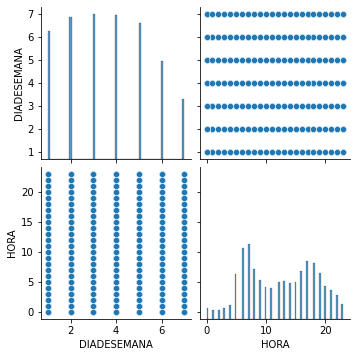

In [405]:
#Se presenta un gráfico general de los datos
sns.pairplot(df_taxis)
plt.show()

Se muestra la matriz de correlación

In [406]:
corr_matrix = df_taxis.corr()
corr_matrix

,DIADESEMANA,HORA
DIADESEMANA,1.000000,0.034171
HORA,0.034171,1.000000


Se visualizan las relación entre variables de los datos

Text(0.5, 51.0, 'X')

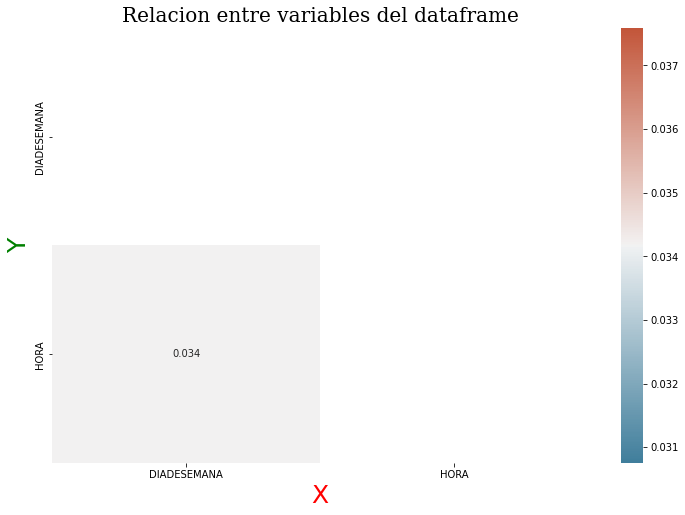

In [407]:
f, ax = plt.subplots(figsize=(12, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, mask = mask, cmap=cmap )
plt.title('Relacion entre variables del dataframe',fontsize=20,fontname='serif')
plt.ylabel('Y', color='green', fontsize=25)
plt.xlabel('X', color='Red', fontsize=25)

### EXPERIMENTOS CON DIFERENTES ENTRENAMIENTOS

In [408]:

"""
#Funcion que permite llenar los servicios tomados con 1 y los no tomados con 0
def setDataService(data, from_date, to_date):
  remaining_days = to_date.date() - from_date.date()
  service_array = []
  for i in range(remaining_days.days+1):
    last_time = from_date + timedelta(days=i)
    if last_time.date().isoweekday() == to_date.date().isoweekday():
      for hour in range(HOURS_OF_DAY):
        #Se filtra por el mismo día de la semana, fecha y hora
        df_service = data[(data['DIADESEMANA'] == last_time.isoweekday()) & (data['FECHA'] == last_time.strftime(FORMAT_DATE)) & (data['HORA'] == hour) ].to_numpy()
        if len(df_service) > 0:
          #Se llena con valor en 1 porqué se encontró un servicio
          service_array.append(np.append(df_service, 1))
        else:
          #Se llena con valor en 0 porqué no se encontró ningún servicio
          service_array.append([last_time.isoweekday(),hour,last_time.month,last_time.date().strftime(FORMAT_DATE),0])
  return pd.DataFrame(service_array, 
             columns=np.append(np.array(data.columns.tolist()), 'SERVICIO'))
"""

"\n#Funcion que permite llenar los servicios tomados con 1 y los no tomados con 0\ndef setDataService(data, from_date, to_date):\n  remaining_days = to_date.date() - from_date.date()\n  service_array = []\n  for i in range(remaining_days.days+1):\n    last_time = from_date + timedelta(days=i)\n    if last_time.date().isoweekday() == to_date.date().isoweekday():\n      for hour in range(HOURS_OF_DAY):\n        #Se filtra por el mismo día de la semana, fecha y hora\n        df_service = data[(data['DIADESEMANA'] == last_time.isoweekday()) & (data['FECHA'] == last_time.strftime(FORMAT_DATE)) & (data['HORA'] == hour) ].to_numpy()\n        if len(df_service) > 0:\n          #Se llena con valor en 1 porqué se encontró un servicio\n          service_array.append(np.append(df_service, 1))\n        else:\n          #Se llena con valor en 0 porqué no se encontró ningún servicio\n          service_array.append([last_time.isoweekday(),hour,last_time.month,last_time.date().strftime(FORMAT_DATE),0])

In [409]:
#limites de decision
def make_meshgrid(X, step=.02):
    x = X.iloc[:,0].values
    y = X.iloc[:,1].values
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    return xx, yy

def plot_contours(ax, clf, X, y, **params):

    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'cyan', 'gray')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    xx, yy = make_meshgrid(X)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        Z[Z == cl] = idx
        ax.scatter(X.loc[y == cl, X.columns[0]], 
                    X.loc[y == cl, X.columns[1]],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl, 
                    edgecolor='black',
                    cmap=cmap,
                    s=50)
    
    ax.legend()
    ax.set_ylabel(X.columns[1])
    ax.set_xlabel(X.columns[0])
    ax.set_title(clf.__class__.__name__)
    ax.grid()    
    out = ax.contourf(xx, yy, Z, alpha=0.2, cmap=cmap)
    
    return out

In [410]:
#ROC Y AUC
def ROC(X, y, model):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

  clf = OneVsRestClassifier(model)
  clf.fit(X_train, y_train)
  pred = clf.predict(X_test)
  pred_prob = clf.predict_proba(X_test)
  pred_prob = np.nan_to_num(pred_prob)

  fpr = {}
  tpr = {}
  thresh ={}

  fig, ax = plt.subplots(figsize=(10,8))
  colors = ('orange', 'green', 'blue')
  
  for index, label_ in enumerate(y.unique()):
    fpr[label_], tpr[label_], thresh[label_] = roc_curve(y_test, pred_prob[:,index], pos_label=label_) 
    ax.plot(fpr[label_], tpr[label_], linestyle='--',color=colors[index], label=label_)
  
  ax.plot([0, 1], [0, 1], linestyle='--',color='red', label='No Skill')
  ax.set_title(f'Multiclass ROC curve -  {model.__class__.__name__}')
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive rate')
  ax.grid(True)
  plt.show()

  return ax.legend(loc='best')

Funcion que permite entrenar el modelo y predecir con los valores de pruebas

In [411]:
def predictModel(model, X_train, y_train, X_test):
    #A continuación se entrena el modelo
    model.fit(X_train, y_train)
    #Se crean las predicciones para pruebas
    y_pred = model.predict(X_test)
    #Se crean las probabilidades para pruebas
    y_prob = model.predict_proba(X_test)
    return model, y_pred, y_prob

Función que permite evaluar el modelo de los K vecinos

In [490]:
def knnModel(X_train, y_train, X_test):
    #Se aplica el modelo de K vecinos
    model = KNeighborsClassifier(n_neighbors=3)
    return predictModel(model, X_train, y_train, X_test)

Función que permite evaluar el modelo de perceptrones multi capa

In [413]:
def mlpModel(X_train, y_train, X_test):
    #Se aplica el modelo de perceptrones multi capa
    model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(30,30, 30), random_state=1,learning_rate_init=0.001,max_iter=5000)
    return predictModel(model, X_train, y_train, X_test)

Función que permite evaluar el modelo de perceptrones

In [414]:
def perModel(X_train, y_train, X_test):
    #Se aplica el modelo de perceptrones multi capa
    model = Perceptron(eta0=0.1, n_iter_no_change=10, random_state=1)
    return predictModel(model, X_train, y_train, X_test)

Función que permite evaluar el modelo de regesión logística

In [415]:
def lrModel(X_train, y_train, X_test):
    #Se aplica el modelo de de regesión logística
    model = LogisticRegression(random_state = 1)
    return predictModel(model, X_train, y_train, X_test)

Función que permite evaluar el modelo de los arboles aleatorios

In [416]:
def rfcModel(X_train, y_train, X_test):
    #Se aplica el modelo de los arboles aleatorios
    model = RandomForestClassifier(criterion='gini', max_depth=5, n_estimators=200, class_weight="balanced")
    return predictModel(model, X_train, y_train, X_test)

Función que permite evaluar el modelo de máquina de soporte de vectores

In [417]:
def svcModel(X_train, y_train, X_test):
    #Se aplica el modelo de máquina de soporte de vectores
    model = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0, class_weight='balanced')#, class_weight='balanced'
    return predictModel(model, X_train, y_train, X_test)

Función que permite evaluar el modelo de los arboles de desiciones

In [418]:
def dtcModel(X_train, y_train, X_test,):
    #Se aplica el modelo de los arboles de desiciones
    model = DecisionTreeClassifier(criterion='gini', max_depth=3, class_weight='balanced')#class_weight={0: 1, 1: 5}
    return predictModel(model, X_train, y_train, X_test)

Función que permite evaluar el modelo de gradiente descendente estocástico

In [419]:
def sgdModel(X_train, y_train, X_test,):
    #Se aplica el modelo de gradiente descendente estocástico
    model =SGDClassifier(loss='huber', random_state=1, max_iter=2000, epsilon=0.1)#loss='hinge'
    return predictModel(model, X_train, y_train, X_test)

Función que permite mostrar la visualización de los datos con subplot

In [420]:
def dataVisualization(df_train):
    #Se visualiza los datos por columnas de entrenamiento
    fig, axes = plt.subplots(1, len(df_train.columns))
    fig.set_size_inches(21,6)
    for i, column in enumerate(df_train.columns):
        sns.histplot(df_train[column], kde=True, ax=axes[i])
    plt.show()

Función que permite mostrar la matriz de confusión

In [421]:
def confusionMatrix(model, y_test, y_pred):
  '''
  plt.rcParams.update({'font.size': 16})
  fig, axes = plt.subplots(figsize=(14, 10))
  disp = ConfusionMatrixDisplay.from_estimator(model,
                                             y_test,
                                             y_pred,
                                             display_labels=model.classes_,
                                             cmap=plt.cm.Blues,
                                             ax=axes
                                             )
  disp.ax_.set_title(f'Confusion Matrix - {model.__class__.__name__}')
  plt.show()
  '''
  plt.rcParams.update({'font.size': 16})
  cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=model.classes_)
  disp.plot()
  plt.show()

In [422]:
def contoursGrap(model, X, y):
    plt.rcParams.update({'font.size': 16})
    fig, axes = plt.subplots(figsize=(12, 10))
    plot_contours(axes, model, X, y, cmap=plt.cm.coolwarm, alpha=0.5)
    plt.show()

Función que permite mostrar los diferentes reportes para comparar los modelos

In [423]:
def reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type):
    if model_type == 'LR':
        #Se imprimen los coeficientes, intresección y número de coeficientes
        print(f"Coeficientes del modelo: {model.coef_}\n")
        print(f"Intresección del modelo: {model.intercept_}\n")
        print(f"Número de coeficientes del modelo: {len(model.coef_)}\n")
    if model_type != 'PR':

        if (model_type != 'SVC') & (model_type != 'SGD'):
            #
            ROC(X_train, y_train, model)
        #
        contoursGrap(model, X_train, y_train)
        #
    #Se muestra la matriz de confusión
    confusionMatrix(model, y_test, y_pred)
    #Se imprime el reporte de clasificación
    #print(classification_report(y_test, y_pred))
    #mae = mean_absolute_error(y_test, y_pred)
    #print("MAE:",(mae))
    
    

Función que permite cálcular la probabilidad de un usuario

In [424]:
def ProbabilisticClassifier(hour, day, data):
  data_array = data.to_numpy()
  first = pd.to_datetime(data.tail(1).iloc[0,2], format=FORMAT_DATE)
  last = pd.to_datetime(data.head(1).iloc[0,2], format=FORMAT_DATE)
  remaining_days = first.date() - last.date()
  total = 0 
  for i in range(remaining_days.days):
    last_time = last + timedelta(days=i)
    if last_time.isoweekday() == day:
      total += 1
  total_onset = 0
  for row in data_array:
    if( ( row[0] == day ) & ( row[1] == hour ) & ( row[3] == 1 ) ):
      total_onset += 1
  if total > 0:
    return total_onset / total
  else:
    return 0

Función que permite evaluar el modelo probabilistico

In [425]:
def probabilisticModel(data, date_predict):
    threshold = 0.5
    array_result = []
    array_prob = []
    for hour in range(HOURS_OF_DAY):
        result = ProbabilisticClassifier(hour, date_predict.isoweekday(), data)
        array_prob.append(round(result,2) if result >= threshold else 0 )
        array_result.append(1 if result >= threshold else 0)
    return array_result, array_prob

In [426]:
#Conversor del codigo a nombre de modelos
def modelName(model_type):
    if model_type == 'LR':
        return 'logistic regression'
    elif model_type == 'KNN':
        return 'kneighbors'
    elif model_type == 'MLP':
        return 'multilayer perceptron'
    elif model_type == 'RFC':
        return 'random forest'
    elif model_type == 'SVC':
        return 'support vector'
    elif model_type == 'SGD':
        return 'gradient descent stochastic'
    elif model_type == 'DTC':
        return 'decision tree'
    elif model_type == 'PR':
        return 'probabilistic model'

In [427]:
#Función para validar si contiene todos los datos en 0
def existAllZero(arr):
    if len(arr)>0:
        for value in arr:
            if value != 0:
                return False
    return True

In [428]:
#Funcion que permite rellenar el dataset con los servicios tomados en 1 y los no tomados en 0
def setDataService(data, from_date, to_date):
  #print("From: ",from_date.date())
  #print("To: ",to_date.date())
  remaining_days = to_date.date() - from_date.date()
  service_array = []
  day_validation = {}
  for i in range(remaining_days.days+1):
    last_time = from_date + timedelta(days=i)
    if last_time.date().isoweekday() == to_date.date().isoweekday():
      day_validation[last_time.strftime(FORMAT_DATE)] = 0
      for hour in range(HOURS_OF_DAY):
        #Se filtra por el mismo día de la semana, fecha y hora
        #df_service = data[(data['DIADESEMANA'] == last_time.isoweekday()) & (data['FECHA'] == last_time.date()) & (data['HORA'] == hour) ].to_numpy()
        df_service = data[(data['FECHA'].astype(str) == last_time.strftime(FORMAT_DATE)) & (data['HORA'] == hour) ].to_numpy()
        if len(df_service) > 0:
          #Se llena con valor en 1 porqué se encontró un servicio
          service_array.append(np.append(df_service, 1))
          day_validation[last_time.strftime(FORMAT_DATE)] += 1
        else:
          #Se llena con valor en 0 porqué no se encontró ningún servicio
          service_array.append([last_time.isoweekday(),hour,last_time.date().strftime(FORMAT_DATE),0])
  return pd.DataFrame(service_array, 
             columns=np.append(np.array(data.columns.tolist()), 'SERVICIO')), day_validation

Función que permite probar los diferentes modelos en un rango de tiempo configurado 

In [467]:

#Función que entrene el modelo y nos devuelva el y_predicted
def evaluate_model(phone, data, date_predict, model_type):
  #Inicialización de vectores
  y_pred = np.empty(0,dtype=int)
  y_prob = np.empty(0,dtype=float)
  y_test = np.empty(0,dtype=int)

  y_result_arr = []
  y_prob_arr = []
  #Se filtra por el número de teléfono
  data = data[data["TELEFONOORIGEN"]==phone].copy()
  #Se elimina el teléfono debido a que no es relevante para el modelo
  data = data.drop(labels=['TELEFONOORIGEN'], axis=1)
  
  #Se obtiene la fecha de inicial de entrenamiento
  date_first_training = date_predict - timedelta(weeks=TRAIN_WEEK)
  
  #Se particiona el dataframe desde la fecha inicial y hasta la fecha final de entrenamiento
  data = data[ (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) >= date_first_training) & (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) <= date_predict) ]
  
  #Se obtiene el tamaño de los datos del usuario
  tam = len(data)

  #Se valida si tiene más de un servicio registrado
  if tam > 1:
    #Se llenan en 0 las horas de los servicios que no se tomaron por el usuario
    data, day_val = setDataService(data, date_first_training, date_predict)
    #Se crear el dataframe de entrenamiento desde la fecha inicial hasta la fecha de predicción
    train = data[ (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) >= date_first_training) & (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) < date_predict) ]
    #Se crear el dataframe de pruebas desde la fecha de predicción hasta una semana adelante
    test = data[(pd.to_datetime(data['FECHA'], format=FORMAT_DATE) == date_predict) ]

    amout_services = 0
    for key, values in day_val.items():
      if (date_predict.strftime(FORMAT_DATE) != key) & (values > 0):
        amout_services += 1

    #Se valida si tiene más de un servicio tomado
    if amout_services >= 3:
      #Datos para probar los modelos
      if model_type != 'PR':
        train = train.loc[:,['DIADESEMANA','HORA','SERVICIO']]
        test = test.loc[:,['DIADESEMANA','HORA','SERVICIO']]
      else:
        train = train.loc[:,['DIADESEMANA','HORA','FECHA','SERVICIO']]

      y_train = train.SERVICIO
      X_train = train.drop(labels='SERVICIO', axis=1)

      y_test = test.SERVICIO
      X_test = test.drop(labels='SERVICIO', axis=1)

      '''
      if model_type != 'PR':
        scaler = PowerTransformer(method='yeo-johnson', standardize=True)
        #scaler = StandardScaler()
        #scaler = MinMaxScaler(feature_range=(0,1))
        #scaler = Normalizer()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        '''
      
      if model_type == 'LR':
        #Se visualiza los datos
        #dataVisualization(train)
        model, y_pred, y_prob = lrModel(X_train, y_train, X_test)
        #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
      elif model_type == 'KNN':
        model, y_pred, y_prob = knnModel(X_train, y_train, X_test)
        #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
      elif model_type == 'MLP':
        model, y_pred, y_prob = mlpModel(X_train, y_train, X_test)
        #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
      elif model_type == 'RFC':
        model, y_pred, y_prob = rfcModel(X_train, y_train, X_test)
        #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
      elif model_type == 'SVC':
        model, y_pred, y_prob = svcModel(X_train, y_train, X_test)
        #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
      elif model_type == 'SGD':
        model, y_pred, y_prob = sgdModel(X_train, y_train, X_test)
        #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
      elif model_type == 'DTC':
        model, y_pred, y_prob = dtcModel(X_train, y_train, X_test)
        #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
      elif model_type == 'PR':
        #Se caulcula el modelo probabilistico
        y_result, y_proba = probabilisticModel(train, date_predict)
        
        y_result_arr.append(y_result)
        y_prob_arr.append(y_proba)
        
        for i in y_result_arr:
          for j in i:
            y_pred = np.append(y_pred, int(j))
        for i in y_prob_arr:
          for j in i:
            y_prob = np.append(y_prob, float(j))
        class model:
          classes_ = np.empty(0,dtype=int)
          name = 'Probabilistic'
        model.classes_ = np.array([0, 1])
        #reportClassification(model, X_train, y_train, y_pred, X_test, y_test, model_type)
      else:
        print("Modelo no existe!")
    #else:
    #  print(f"No hay servicios suficientes para la fecha:{date_predict} del usuario:{phone}!")
  return y_pred, y_test, y_prob

Se crea un nuevo dataFrame con los números de teléfonos para recorrer los modelos

In [499]:
total_phone, count, phone_array = 100, 0, []
df_phone = df_taxis.loc[:,['TELEFONOORIGEN']].copy()
series_phone = df_phone.loc[:,['TELEFONOORIGEN']].value_counts()
for phone in series_phone.index.to_list():
    if count < total_phone:
        count += 1
        phone_array.append(phone[0]) 
#print(phone_array)
#series_phone

Validamos los hiperparámetros de los modelos

In [498]:
from sklearn.model_selection import GridSearchCV
#Se quitan los modelos 'LR','SVC','SGD','DTC','MLP' por mal rendimiento
#models_array = ['PR','KNN','RFC','DTC']
models_array = ['KNN']
report_models = []
roc_curve_arr = []
start_proccess = datetime.now()
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,7))
n_neighbors = list(range(1,7))
p=[1,2]
print(f"Inició el proceso: {datetime.now()}")
for model in models_array:
    start_date = datetime.now()
    confusion_phone = np.matrix(0,dtype=int)
    y_test_arr = np.array(0,dtype=int)
    y_prob_arr = np.array(0,dtype=float)
    for phone in phone_array:
        print(f'---------------------------{phone}------------------------------')
        remaining_days = DATE_START_TRAINIG.date() + timedelta(days=7) - DATE_START_TRAINIG.date()
        for i in range(remaining_days.days):
            last_time = DATE_START_TRAINIG.date() + timedelta(days=i)
            
            #Se obtiene la fecha de inicial de entrenamiento
            date_first_training = pd.to_datetime(last_time, format=FORMAT_DATE) - timedelta(weeks=TRAIN_WEEK)

            data = df_taxis[df_taxis["TELEFONOORIGEN"]==phone].copy()

            #Se llenan en 0 las horas de los servicios que no se tomaron por el usuario
            data, day_val = setDataService(data, date_first_training, pd.to_datetime(last_time, format=FORMAT_DATE))
            #Se crear el dataframe de entrenamiento desde la fecha inicial hasta la fecha de predicción
            train = data[ (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) >= date_first_training) & (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) < pd.to_datetime(last_time, format=FORMAT_DATE)) ]
            #Se crear el dataframe de pruebas desde la fecha de predicción hasta una semana adelante
            test = data[(pd.to_datetime(data['FECHA'], format=FORMAT_DATE) == pd.to_datetime(last_time, format=FORMAT_DATE)) ]
            amout_services = 0
            for key, values in day_val.items():
                if (pd.to_datetime(last_time, format=FORMAT_DATE).strftime(FORMAT_DATE) != key) & (values > 0):
                    amout_services += 1

            #Se valida si tiene más de un servicio tomado
            if amout_services >= 3:
                if model != 'PR':
                    train = train.loc[:,['DIADESEMANA','HORA','SERVICIO']]
                    test = test.loc[:,['DIADESEMANA','HORA','SERVICIO']]
                else:
                    train = train.loc[:,['DIADESEMANA','HORA','FECHA','SERVICIO']]

                y_train = train.SERVICIO
                X_train = train.drop(labels='SERVICIO', axis=1)

                y_test = test.SERVICIO
                X_test = test.drop(labels='SERVICIO', axis=1)

                
                #Convert to dictionary
                hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
                #Create new KNN object
                knn_2 = KNeighborsClassifier()
                #Use GridSearch
                clf = GridSearchCV(knn_2, hyperparameters, cv=10)
                #Fit the model
                best_model = clf.fit(X_train,y_train)
                #Print The value of best Hyperparameters
                print(f'---------------------------{last_time}------------------------------')
                print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
                print('Best p:', best_model.best_estimator_.get_params()['p'])
                print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

            

Inició el proceso: 2023-04-16 21:27:50.828538
---------------------------3107584482------------------------------
---------------------------2022-02-11------------------------------
Best leaf_size: 1
Best p: 1
Best n_neighbors: 1
---------------------------2022-02-12------------------------------
Best leaf_size: 1
Best p: 1
Best n_neighbors: 1
---------------------------2022-02-13------------------------------
Best leaf_size: 1
Best p: 1
Best n_neighbors: 1
---------------------------2022-02-14------------------------------
Best leaf_size: 1
Best p: 1
Best n_neighbors: 1
---------------------------2022-02-15------------------------------
Best leaf_size: 1
Best p: 1
Best n_neighbors: 1
---------------------------2022-02-16------------------------------
Best leaf_size: 1
Best p: 1
Best n_neighbors: 1
---------------------------2022-02-17------------------------------
Best leaf_size: 1
Best p: 1
Best n_neighbors: 1
---------------------------3503758291------------------------------
------

ValueError: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=9.

# Evaluación de los modelos

Experimento con todos los modelos para una semana

In [500]:
#Se quitan los modelos 'LR','SVC','SGD','DTC','MLP' por mal rendimiento
models_array = ['PR','KNN','RFC','DTC']
#models_array = ['KNN']
report_models = []
roc_curve_arr = []
start_proccess = datetime.now()
print(f"Inició el proceso: {datetime.now()}")
for model in models_array:
    start_date = datetime.now()
    count = 0
    kappa_score = 0.0
    test_score = 0
    roc_score = 0.0
    confusion_phone = np.matrix(0,dtype=int)
    y_test_arr = np.array(0,dtype=int)
    y_prob_arr = np.array(0,dtype=float)
    for phone in phone_array:
        remaining_days = DATE_START_TRAINIG.date() + timedelta(days=7) - DATE_START_TRAINIG.date()
        for i in range(remaining_days.days):
            last_time = DATE_START_TRAINIG.date() + timedelta(days=i)
            y_pred, y_test, y_prob = evaluate_model(phone, df_taxis, pd.to_datetime(last_time, format=FORMAT_DATE), model)
            #if(not existAllZero(y_pred)) & (not existAllZero(y_test)):
            if len(y_prob)>0:
                y_test = y_test.values[:]
                y_prob = [y_prob[:, 1] if model != 'PR' else y_prob[:] ]
                y_test_arr = np.concatenate((y_test_arr, y_test), axis=None)
                y_prob_arr = np.concatenate((y_prob_arr, y_prob), axis=None)
            if len(y_pred) > 1:
                
                try:
                    matrix = np.matrix(confusion_matrix(y_test, y_pred))
                    if matrix.size == 1:
                        matrix = np.matrix([[24,0],[0,0]],dtype=int)
                    confusion_phone = confusion_phone + matrix
                except Exception as err:
                    confusion_phone = confusion_phone
                try:
                    score_k = cohen_kappa_score(y_test, y_pred)
                    kappa_score += (0.0 if math.isnan (score_k) else score_k)
                except Exception as err:
                    kappa_score += 0
                test_score += np.mean(y_pred == y_test)
                #
                try:
                    roc_score += roc_auc_score(y_test, y_pred)
                except Exception as err:
                    roc_score += 0.0
                    #print(f"Unexpected {err=}, {type(err)=} - {y_test} - {y_pred}")
                count = count + 1
                #if(existAllZero(y_pred)) & (existAllZero(y_test)):
                #    print(f"Procesando el teléfono: {phone[0]} y la fecha: {last_time}, confusion: {matrix}, tamanio: {matrix.size}")
                #    print(f"{y_test} \n {y_pred} \n {y_prob}")
            #else:
            #    print(f"Procesando el teléfono: {phone} pero sin predictibilidad")
    roc_curve_arr.append([model, y_test_arr, y_prob_arr])
    report_models.append([model,confusion_phone, (kappa_score/count) if kappa_score > 0 else 0, (test_score/count) if test_score > 0 else 0, (roc_score/count) if roc_score > 0 else 0])
    print(f"Procesó el modelo {model} en: {datetime.now()-start_date}")
print(f"Finalizó el proceso: {datetime.now()} en {datetime.now()-start_proccess}")
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html

Inició el proceso: 2023-04-16 21:32:40.633968


c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:663: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:663: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:663: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:663: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\met

Procesó el modelo PR en: 0:01:03.822851


c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:663: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:663: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:663: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:663: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\met

Procesó el modelo KNN en: 0:00:58.512266


c:\Users\de_la\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:663: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Procesó el modelo RFC en: 0:02:42.344608
Procesó el modelo DTC en: 0:00:57.132317
Finalizó el proceso: 2023-04-16 21:38:22.446010 en 0:05:41.812042


Se ejecuta la matriz de confusión de los modelos

In [501]:
models_array = []
for model in report_models:
    true_neg = model[1][0,0]
    true_pos = model[1][1,1]
    false_pos = model[1][0,1]
    false_neg = model[1][1,0]
    kappa = model[2]
    test_score = model[3]
    roc = model[4]

    #Precision = TruePositives / (TruePositives + FalsePositives)
    precision_scr = true_pos / (true_pos + false_pos) if true_pos > 0 else 0
    #Recall = TruePositives / (TruePositives + FalseNegatives)

    
    recall_scr = true_pos / (true_pos + false_neg) if true_pos > 0 else 0
    #F-Measure = (2 * Precision * Recall) / (Precision + Recall)
    f1_scr = (2 * precision_scr * recall_scr) / (precision_scr + recall_scr) if true_pos > 0 else 0

    #Sacar la tasa de los TP = Que es Positivos del test sobre los positivos predichos
    #TP rate = TP / Positivos reales (test)
    #FP rate = FP / Negativos reales (test)

    models_array.append([modelName(model[0]),
                         round(precision_scr,2),
                         round(recall_scr,2),
                         round(f1_scr,2),
                         true_neg,
                         true_pos,
                         false_pos,
                         false_neg,
                         round(kappa,2),
                         round(test_score,2),
                         round(roc,2)])

#Mostramos el dataframe con el reporte
pd.DataFrame(models_array, columns = ['MODEL','PRECISION','RECALL','F1','TN','TP','FP','FN','KAPPA','SCORE TEST','ROC'])

,MODEL,PRECISION,RECALL,F1,TN,TP,FP,FN,KAPPA,SCORE TEST,ROC
0,probabilistic model,0.36,0.15,0.21,13609,211,382,1182,0.11,0.90,0.45
1,kneighbors,0.32,0.13,0.18,13622,175,369,1218,0.09,0.90,0.44
2,random forest,0.21,0.46,0.29,11550,643,2441,750,0.17,0.79,0.52
3,decision tree,0.16,0.72,0.26,8564,1006,5427,387,0.14,0.62,0.54


kneighbors: ROC AUC=0.614


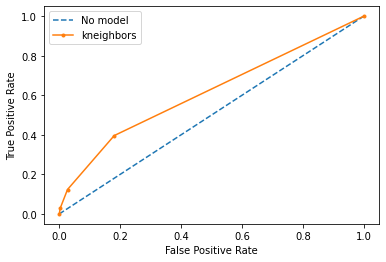

In [486]:
#Se muestra la curva ROC de los modelos
for roc in roc_curve_arr:
    if not existAllZero(roc[1]):
        ns_probs = [0 for _ in range(len(roc[1]))]
        # calculate scores
        ns_auc = roc_auc_score(roc[1], ns_probs)
        lr_auc = roc_auc_score(roc[1], roc[2])
        # summarize scores
        
        print(f'{modelName(roc[0])}: ROC AUC=%.3f' % (lr_auc))
        # calculate roc curves
        ns_fpr, ns_tpr, _ = roc_curve(roc[1], ns_probs)
        lr_fpr, lr_tpr, _ = roc_curve(roc[1], roc[2])
        # plot the roc curve for the model
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No model')
        plt.plot(lr_fpr, lr_tpr, marker='.', label=modelName(roc[0]))
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        # show the legend
        plt.legend()
        # show the plot
        plt.show()
    else:
        print(f"El modelo {modelName(roc[0])} no tiene valores para mostrar")